In [1]:
import gym
from env.custom_hopper import *
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt


/home/federica/anaconda3/envs/mldl/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
class Policy(nn.Module):
    def __init__(self, state_space, action_space):
        super().__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.hidden = 64
        self.tanh = nn.Tanh()

        # Shared network
        self.embedding_ac = nn.Linear(state_space, 64)
        self.relu = nn.ReLU()
        self.fc1_ac = nn.Linear(64, 64) #changed from 2048 to 1024
        #self.lstm_ac = nn.LSTM(1024, 512, batch_first=True)

        # Actor network
        self.fc2_actor = nn.Linear(64, action_space)

        # Critic network
        self.fc2_critic = nn.Linear(64, 1) 

        # Learned standard deviation for exploration
        self.sigma_activation = F.softplus
        init_sigma = 0.5
        self.sigma = nn.Parameter(torch.zeros(self.action_space) + init_sigma)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) #changed form normal_ to xavier_normal_
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.embedding_ac(x)
        x = self.relu(x)
        x = self.fc1_ac(x)
        x = self.relu(x)
        #x, _ = self.lstm_ac(x.unsqueeze(0))  # Adding batch dimension for LSTM
        #x = x.squeeze(1)  # Remove sequence dimension

        # Actor
        action_mean = self.fc2_actor(x.squeeze(0))
        action_sigma = self.sigma_activation(self.sigma)
        normal_dist = Normal(action_mean, action_sigma)

        # Critic
        value = self.fc2_critic(x.squeeze(0))

        return normal_dist, value


In [11]:
def bootstrapped_discount_rewards(r, gamma, done, next_values):
    bootstrapped_discounted_r = torch.zeros_like(r)
    for t in reversed(range(0, r.size(-1))):
         if done[t]:
             bootstrapped_discounted_r[t] = r[t]
         else:
             bootstrapped_discounted_r[t] = r[t] + gamma*next_values[t]
    return bootstrapped_discounted_r

In [12]:
class Agent(object):
    def __init__(self, policy, actor_lr, critic_lr, device='cpu'):
        self.train_device = device
        self.policy = policy.to(self.train_device)
        self.optimizer_actor = torch.optim.Adam([param for name, param in policy.named_parameters() if 'actor' in name], lr=actor_lr)
        self.optimizer_critic = torch.optim.Adam([param for name, param in policy.named_parameters() if 'critic' in name], lr=critic_lr)

        self.gamma = 0.99
        self.states = []
        self.next_states = []
        self.action_log_probs = []
        self.rewards = []
        self.done = []

    def update_policy(self):
        action_log_probs = torch.stack(self.action_log_probs, dim=0).to(self.train_device).squeeze(-1)
        states = torch.stack(self.states, dim=0).to(self.train_device).squeeze(-1)
        next_states = torch.stack(self.next_states, dim=0).to(self.train_device).squeeze(-1)
        rewards = torch.stack(self.rewards, dim=0).to(self.train_device).squeeze(-1)
        done = torch.Tensor(self.done).to(self.train_device)

        self.states, self.next_states, self.action_log_probs, self.rewards, self.done = [], [], [], [], []

        #Compute bootstrapped discount estimates
        ## compute estimated values of the current state and of the next state
        _, v_currentstate = self.policy(states)
        _, v_nextstate = self.policy(next_states)
        ## bootstrapped discounted returns r_t+gamma*V(s_t+1)*(1-done)
        bootstrapped_discount_r = bootstrapped_discount_rewards(rewards, self.gamma, done, v_nextstate)

        #Compute advantage terms (TD error)
        advantages = bootstrapped_discount_r - v_currentstate.detach()
        ## .detach() is used to ensure that the value estimates used in the advantage calculation do not contribute to the gradient
        ## computations for updating the policy.
        
        #Compute actor and critic loss
        actor_loss = -(action_log_probs * advantages.detach()).mean()
        critic_loss =  torch.mean((bootstrapped_discount_r - v_currentstate) ** 2)
        
        total_loss = actor_loss+critic_loss

        #compute gradients
        self.optimizer_actor.zero_grad()
        self.optimizer_critic.zero_grad()
        ## backproagate the total loss
        actor_loss.backward(retain_graph=False) #trying to put false
        critic_loss.backward()

        #Step optimizer
        self.optimizer_actor.step()
        self.optimizer_critic.step()

    def get_action(self, state, evaluation=False):
        x = torch.from_numpy(state).float().to(self.train_device)
        normal_dist, _ = self.policy(x)

        if evaluation:
            return normal_dist.mean, None
        else:
            action = normal_dist.sample()
            action_log_prob = normal_dist.log_prob(action).sum()
            return action, action_log_prob

    def store_outcome(self, state, next_state, action_log_prob, reward, done):
        self.states.append(torch.from_numpy(state).float())
        self.next_states.append(torch.from_numpy(next_state).float())
        self.action_log_probs.append(action_log_prob)
        self.rewards.append(torch.Tensor([reward]))
        self.done.append(done)

In [13]:
def train(env, agent, num_episodes, max_steps):
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        for step in range(max_steps):
            action, action_log_prob = agent.get_action(state)
            next_state, reward, done, _ = env.step(action.numpy())
            
            agent.store_outcome(state, next_state, action_log_prob, reward, done)
            episode_reward += reward
            state = next_state

            if done:
                break

        agent.update_policy()
        episode_rewards.append(episode_reward)

        avg_reward = np.mean(episode_rewards)
        print(f"Episode {episode + 1}, Average Reward: {avg_reward:.2f}")
        
    return episode_rewards

Episode 1, Average Reward: 90.30
Episode 2, Average Reward: 47.56
Episode 3, Average Reward: 45.68
Episode 4, Average Reward: 40.36
Episode 5, Average Reward: 34.98
Episode 6, Average Reward: 31.08
Episode 7, Average Reward: 26.82
Episode 8, Average Reward: 23.93
Episode 9, Average Reward: 21.50
Episode 10, Average Reward: 20.15
Episode 11, Average Reward: 18.93
Episode 12, Average Reward: 18.01
Episode 13, Average Reward: 18.60
Episode 14, Average Reward: 18.32
Episode 15, Average Reward: 17.71
Episode 16, Average Reward: 17.06
Episode 17, Average Reward: 16.81
Episode 18, Average Reward: 16.14
Episode 19, Average Reward: 15.95
Episode 20, Average Reward: 16.47
Episode 21, Average Reward: 15.85
Episode 22, Average Reward: 15.51
Episode 23, Average Reward: 15.35
Episode 24, Average Reward: 15.11
Episode 25, Average Reward: 14.88
Episode 26, Average Reward: 14.59
Episode 27, Average Reward: 14.15
Episode 28, Average Reward: 13.92
Episode 29, Average Reward: 13.63
Episode 30, Average Rew

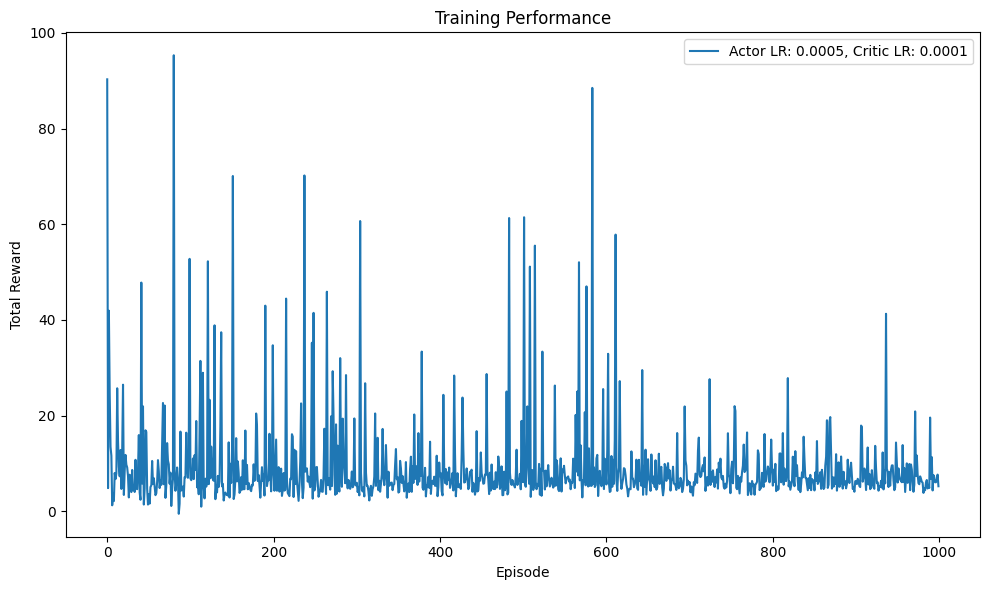

In [14]:
if __name__ == "__main__":
    env = gym.make('CustomHopper-v0')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    actor_lr = 5e-4
    critic_lr = 1e-4

    num_episodes = 1000
    max_steps = 1000

    policy = Policy(state_dim, action_dim)
    agent = Agent(policy, actor_lr=actor_lr, critic_lr=critic_lr)
    episode_rewards = train(env, agent, num_episodes, max_steps)
    
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards, label=f"Actor LR: {actor_lr}, Critic LR: {critic_lr}")
    plt.title(f"Training Performance")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.tight_layout()
    plt.show()

    env.close()

### Training with LR scheduler
training or validation performance stops improving. This scheduler reduces the learning rate when a monitored metric (like loss) has plateaued.


In [15]:
import torch.optim.lr_scheduler as lr_scheduler

In [20]:
class Agent(object):
    def __init__(self, policy, actor_lr, critic_lr, device='cpu'):
        self.train_device = device
        self.policy = policy.to(self.train_device)
        self.optimizer_actor = torch.optim.Adam([param for name, param in policy.named_parameters() if 'actor' in name], lr=actor_lr)
        self.optimizer_critic = torch.optim.Adam([param for name, param in policy.named_parameters() if 'critic' in name], lr=critic_lr)

        #Initialize the scheduler
        self.scheduler_actor = lr_scheduler.ReduceLROnPlateau(self.optimizer_actor, mode='min', factor=0.5, patience=5)
        self.scheduler_critic = lr_scheduler.ReduceLROnPlateau(self.optimizer_critic, mode='min', factor=0.5, patience=5)


        self.gamma = 0.99
        self.states = []
        self.next_states = []
        self.action_log_probs = []
        self.rewards = []
        self.done = []

    def update_policy(self):
        action_log_probs = torch.stack(self.action_log_probs, dim=0).to(self.train_device).squeeze(-1)
        states = torch.stack(self.states, dim=0).to(self.train_device).squeeze(-1)
        next_states = torch.stack(self.next_states, dim=0).to(self.train_device).squeeze(-1)
        rewards = torch.stack(self.rewards, dim=0).to(self.train_device).squeeze(-1)
        done = torch.Tensor(self.done).to(self.train_device)

        self.states, self.next_states, self.action_log_probs, self.rewards, self.done = [], [], [], [], []

        #Compute bootstrapped discount estimates
        ## compute estimated values of the current state and of the next state
        _, v_currentstate = self.policy(states)
        _, v_nextstate = self.policy(next_states)
        ## bootstrapped discounted returns r_t+gamma*V(s_t+1)*(1-done)
        bootstrapped_discount_r = bootstrapped_discount_rewards(rewards, self.gamma, done, v_nextstate)

        #Compute advantage terms (TD error)
        advantages = bootstrapped_discount_r - v_currentstate.detach()
        ## .detach() is used to ensure that the value estimates used in the advantage calculation do not contribute to the gradient
        ## computations for updating the policy.
        
        #Compute actor and critic loss
        actor_loss = -(action_log_probs * advantages.detach()).mean()
        critic_loss =  torch.mean((bootstrapped_discount_r - v_currentstate) ** 2)
        
        total_loss = actor_loss+critic_loss

        #compute gradients
        self.optimizer_actor.zero_grad()
        self.optimizer_critic.zero_grad()
        ## backproagate the total loss
        actor_loss.backward(retain_graph=False) #trying to put false
        critic_loss.backward()

        #Step optimizer
        self.optimizer_actor.step()
        self.optimizer_critic.step()

        #Step the scheduler
        self.scheduler_actor.step(actor_loss)
        self.scheduler_critic.step(critic_loss)

    def get_action(self, state, evaluation=False):
        x = torch.from_numpy(state).float().to(self.train_device)
        normal_dist, _ = self.policy(x)

        if evaluation:
            return normal_dist.mean, None
        else:
            action = normal_dist.sample()
            action_log_prob = normal_dist.log_prob(action).sum()
            return action, action_log_prob

    def store_outcome(self, state, next_state, action_log_prob, reward, done):
        self.states.append(torch.from_numpy(state).float())
        self.next_states.append(torch.from_numpy(next_state).float())
        self.action_log_probs.append(action_log_prob)
        self.rewards.append(torch.Tensor([reward]))
        self.done.append(done)

Episode 1, Average Reward: 5.52
Episode 2, Average Reward: 4.77
Episode 3, Average Reward: 5.02
Episode 4, Average Reward: 5.54
Episode 5, Average Reward: 6.03
Episode 6, Average Reward: 6.63
Episode 7, Average Reward: 6.80
Episode 8, Average Reward: 7.08
Episode 9, Average Reward: 7.35
Episode 10, Average Reward: 7.08
Episode 11, Average Reward: 7.08
Episode 12, Average Reward: 7.04
Episode 13, Average Reward: 6.95
Episode 14, Average Reward: 7.13
Episode 15, Average Reward: 7.56
Episode 16, Average Reward: 7.82
Episode 17, Average Reward: 7.76
Episode 18, Average Reward: 7.96
Episode 19, Average Reward: 8.25
Episode 20, Average Reward: 8.51
Episode 21, Average Reward: 8.69
Episode 22, Average Reward: 8.70
Episode 23, Average Reward: 8.91
Episode 24, Average Reward: 9.30
Episode 25, Average Reward: 9.20
Episode 26, Average Reward: 9.16
Episode 27, Average Reward: 9.08
Episode 28, Average Reward: 8.94
Episode 29, Average Reward: 8.95
Episode 30, Average Reward: 8.86
Episode 31, Average

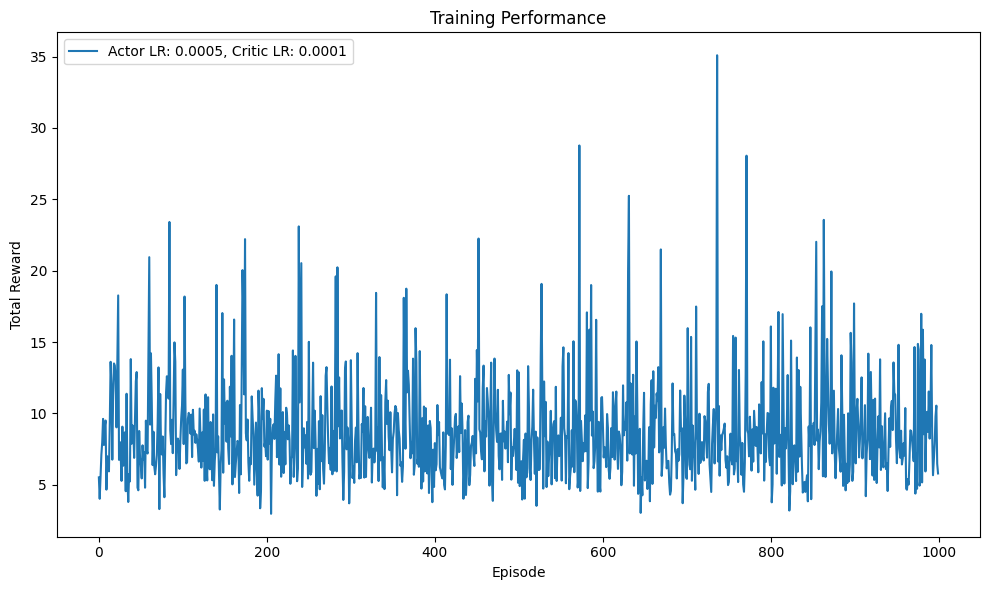

In [21]:
if __name__ == "__main__":
    env = gym.make('CustomHopper-v0')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    actor_lr = 5e-4
    critic_lr = 1e-4

    num_episodes = 1000
    max_steps = 1000

    policy = Policy(state_dim, action_dim)
    agent = Agent(policy, actor_lr=actor_lr, critic_lr=critic_lr)
    episode_rewards = train(env, agent, num_episodes, max_steps)
    
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards, label=f"Actor LR: {actor_lr}, Critic LR: {critic_lr}")
    plt.title(f"Training Performance")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.tight_layout()
    plt.show()

    env.close()

### Adding entropy 
Best for increasing exploration and mitigate the high variance in rewards

In [28]:
import torch
import torch.nn.functional as F

class Agent(object):
    def __init__(self, policy, actor_lr, critic_lr, device='cpu', entropy_coefficient=0.01):
        self.train_device = device
        self.policy = policy.to(self.train_device)
        self.optimizer_actor = torch.optim.Adam([param for name, param in policy.named_parameters() if 'actor' in name], lr=actor_lr)
        self.optimizer_critic = torch.optim.Adam([param for name, param in policy.named_parameters() if 'critic' in name], lr=critic_lr)
        self.entropy_coefficient = entropy_coefficient

        #Initialize the scheduler
        self.scheduler_actor = lr_scheduler.ReduceLROnPlateau(self.optimizer_actor, mode='min', factor=0.5, patience=5)
        self.scheduler_critic = lr_scheduler.ReduceLROnPlateau(self.optimizer_critic, mode='min', factor=0.5, patience=5)

        self.gamma = 0.99
        self.states = []
        self.next_states = []
        self.action_log_probs = []
        self.rewards = []
        self.done = []
        

    def update_policy(self):
        action_log_probs = torch.stack(self.action_log_probs, dim=0).to(self.train_device).squeeze(-1)
        states = torch.stack(self.states, dim=0).to(self.train_device).squeeze(-1)
        next_states = torch.stack(self.next_states, dim=0).to(self.train_device).squeeze(-1)
        rewards = torch.stack(self.rewards, dim=0).to(self.train_device).squeeze(-1)
        done = torch.Tensor(self.done).to(self.train_device)

        self.states, self.next_states, self.action_log_probs, self.rewards, self.done = [], [], [], [], []

        # Compute bootstrapped discount estimates
        _, v_currentstate = self.policy(states)
        _, v_nextstate = self.policy(next_states)
        bootstrapped_discount_r = bootstrapped_discount_rewards(rewards, self.gamma, done, v_nextstate)

        # Compute advantage terms (TD error)
        advantages = bootstrapped_discount_r - v_currentstate.detach()

        # Compute actor loss with entropy regularization
        entropy = -torch.sum(action_log_probs * action_log_probs.exp())
        actor_loss = -(action_log_probs * advantages.detach()).mean() - self.entropy_coefficient * entropy

        # Compute critic loss
        critic_loss = torch.mean((bootstrapped_discount_r - v_currentstate) ** 2)

        # Update actor and critic
        self.optimizer_actor.zero_grad()
        self.optimizer_critic.zero_grad()

        actor_loss.backward(retain_graph=True)
        critic_loss.backward()


        #Step the scheduler
        self.scheduler_actor.step(actor_loss)
        self.scheduler_critic.step(critic_loss)

    def get_action(self, state, evaluation=False):
        x = torch.from_numpy(state).float().to(self.train_device)
        normal_dist, _ = self.policy(x)

        if evaluation:
            return normal_dist.mean, None
        else:
            action = normal_dist.sample()
            action_log_prob = normal_dist.log_prob(action).sum()
            return action, action_log_prob

    def store_outcome(self, state, next_state, action_log_prob, reward, done):
        self.states.append(torch.from_numpy(state).float())
        self.next_states.append(torch.from_numpy(next_state).float())
        self.action_log_probs.append(action_log_prob)
        self.rewards.append(torch.Tensor([reward]))
        self.done.append(done)

Episode 1, Average Reward: 6.09
Episode 2, Average Reward: 9.26
Episode 3, Average Reward: 12.64
Episode 4, Average Reward: 11.52
Episode 5, Average Reward: 13.36
Episode 6, Average Reward: 25.29
Episode 7, Average Reward: 22.56
Episode 8, Average Reward: 28.55
Episode 9, Average Reward: 25.97
Episode 10, Average Reward: 36.56
Episode 11, Average Reward: 34.31
Episode 12, Average Reward: 32.38
Episode 13, Average Reward: 31.41
Episode 14, Average Reward: 32.78
Episode 15, Average Reward: 31.94
Episode 16, Average Reward: 31.01
Episode 17, Average Reward: 29.62
Episode 18, Average Reward: 29.82
Episode 19, Average Reward: 28.98
Episode 20, Average Reward: 28.32
Episode 21, Average Reward: 27.70
Episode 22, Average Reward: 27.30
Episode 23, Average Reward: 27.97
Episode 24, Average Reward: 27.80
Episode 25, Average Reward: 27.09
Episode 26, Average Reward: 26.32
Episode 27, Average Reward: 28.60
Episode 28, Average Reward: 30.19
Episode 29, Average Reward: 30.10
Episode 30, Average Rewar

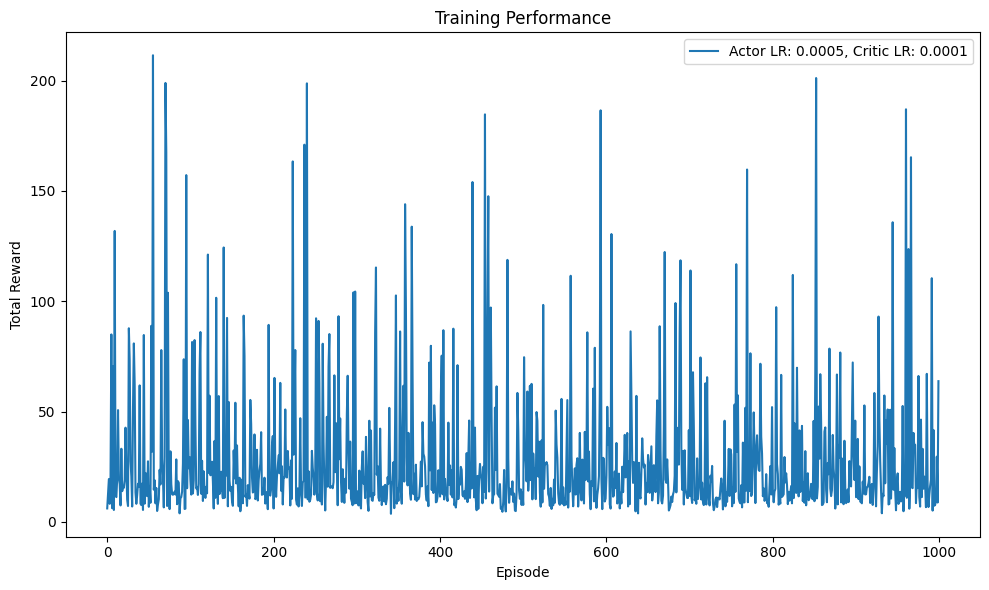

In [29]:
if __name__ == "__main__":
    env = gym.make('CustomHopper-v0')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    actor_lr = 5e-4
    critic_lr = 1e-4

    num_episodes = 1000
    max_steps = 1000

    policy = Policy(state_dim, action_dim)
    agent = Agent(policy, actor_lr=actor_lr, critic_lr=critic_lr)
    episode_rewards = train(env, agent, num_episodes, max_steps)
    
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards, label=f"Actor LR: {actor_lr}, Critic LR: {critic_lr}")
    plt.title(f"Training Performance")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.tight_layout()
    plt.show()

    env.close()